# Clustering using betweenness-based graph algorithms

Transparency it was in fact my 416 homework to code this algorithm but it was quite tricky and I'm quite proud of it so yay for reduce reuse recycle! 

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

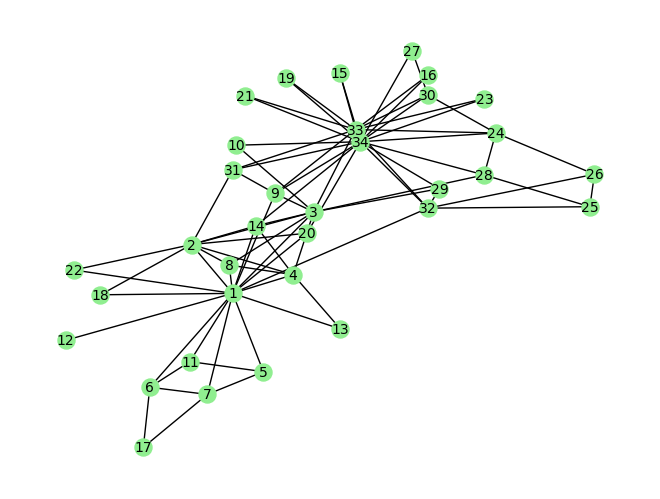

In [3]:
# we will get our data in here soon!
karate = nx.read_gml(r"C:\Users\dodie\Downloads\spring 2024\cse 416\hw4-julia_tompkins\karate\karate.gml", label=None)
nx.draw(karate, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)

In [4]:
def girvan_newman(graph,k):
    G = graph.copy()
    G_nodes = list(G.nodes())
    G_edges = list(G.edges())

    while (nx.number_connected_components(G) < k):
        total_betweenness = {key: 0 for key in G_edges}
        # repeat the process with every node as the source node
        for v in G_nodes:
            # construct an edge list and successor list using BFS
            edge_list = list(nx.bfs_edges(G,v))
            succ_list = list(nx.bfs_successors(G, v))

            # initialize dictionaries for number of shortest paths and beweenness contribution
            sps = {key: 0 for key in G_nodes}
            incoming_flows = {key: 0 for key in G_nodes}
            betweenness = {key: 0 for key in G_edges}
            sps[v] = 1

            # number shortest paths = sum of number of parents' shortest paths
            for i in range(len(succ_list)):
                for n in succ_list[i][1]:
                    sps[n] = sps[n] + sps[succ_list[i][0]] # add number of shortest paths from parents

            # start from the bottom
            for i in range(len(succ_list)-1, -1, -1):
                # for each node, find its parents and their values
                for n in succ_list[i][1]:
                    parents = [e[0] for e in edge_list if e[1] == n]
                    sum_parent_values = np.sum([sps[p] for p in parents])
                    edges_to_spread = [(p,n) for p in parents]
                    # spread flow (1+incoming) proportional to parent values
                    for e in edges_to_spread:
                        incoming_flow = np.sum([betweenness[ed] for ed in edge_list if ed[0] == n])
                        betweenness[e] = (sps[e[0]]/sum_parent_values)*(1+incoming_flow)

            # update total betweenness
            for e in G_edges:
                total_betweenness[e] = total_betweenness[e] + betweenness[e]
                
        # remove edge with maximum betweenness score
        to_remove = max(total_betweenness, key=total_betweenness.get)
        G.remove_edge(to_remove[0], to_remove[1])
        G_edges.remove(to_remove)
        
    return G

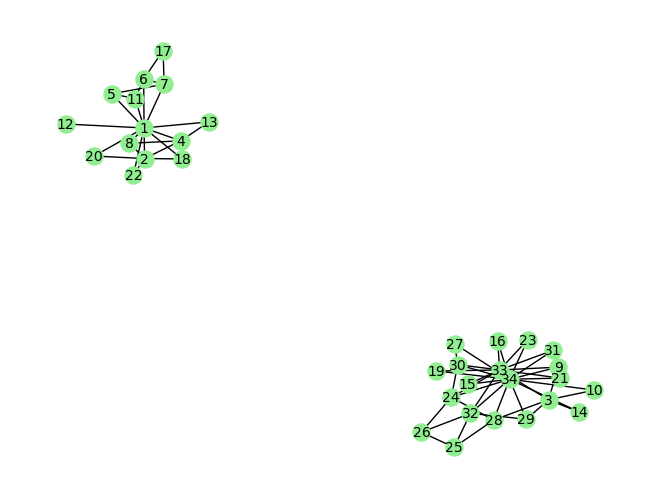

In [6]:
k = 2
test = girvan_newman(karate,k)
nx.draw(test, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)
plt.show()